<a href="https://colab.research.google.com/github/danielsabino/ppgti3007_cv_2021_2/blob/main/semana03/aula05/%5Bnotebook%5Dcv_w03_02_reconhecimento_facial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconhecimento facial

O reconhecimento facial é o processo de identificar a qual pessoa uma face presente em uma imagem pertence. Ou seja, o reconhecimento facial identifica uma pessoa a partir de uma imagem.

Inicialmente, os sistemas de reconhecimento facial eram baseados em marcos (*landmarks*) exraídos da face, como a posição relativa e tamanho dos olhos, nariz e boca. Tais sistemas possuiam suas limitações e tendiam a errar bastante.

Os métodos mais recentes se baseiam em características extraídas da face e o processo de reconhecimento auxiliado por aprendizado de máquina. De fato, as técncias mais recentes se baseiam em modelos profundos de redes convolucionais e são robustos o suficiente para se sair bem na maior parte das situações.

Existem, por outro lado, outras técnicas usadas até hoje para realizar essa tarefa com desepenho satisfatório em situações controladas. Vamos mostrar duas dessas técnicas a seguir: 
1. Local Binary Patterns (LBP)
2. Eigenfaces

# LBP

*Local Binary Patterns* (LBP) é um método relativamente simples para realizar o reconhecimento facial. Ele consiste em dividir a imagem em pequenas células e computar histogramas dos padrões de pixels vizinhos dentros dessas células. Com isso, criamos uma nova identidade espacial da imagem (grid de células) onde é possível identificar partes específicas da face (como olhos, boca, nariz).

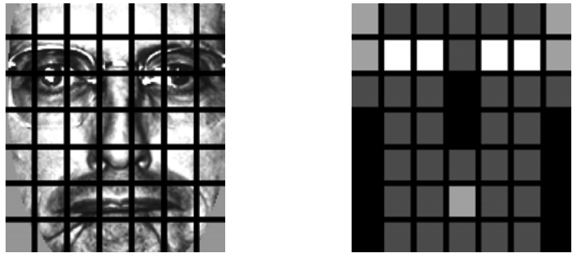

Fonte: https://customers.pyimagesearch.com/lessons/lbps-for-face-recognition/

Essa codificação também nos permite realizar ponderações diferentes para partes distintas da imagem. Na imagem anterior, células com cores mais claras possuem peso maior na determinação de *features* de interesse. Ou seja, as áreas dos olhos, por exemplo, possuem um peso quatro vezes maior que as células cinza escuro, enquanto que células pretas possuem peso zero. 

Para codificar uma face, basta calcular os histogramas de cada uma células do grid, ponderar pelo esquema de pesos e concatenar todos os histogramas em um único vetor (semelhante ao que se faz na extração dos histogramas de gradiente orientado).

A partir desse conceito, o algoritmo de reconhecimento facial é bastante simples, dado que temos uma base de imagens:

1. uma nova face é apresentada ao sistema;
2. os LBPs são extraídos, ponderados e concatenados da mesma maneira que as faces da base de dados;
3. é calculada a distância para todas as faces da base;
4. o nome associado com a face mais próxima é retornada.

Uma grande vantagem desse modelo é a facilidade de incorporação de novas faces à base de dados. Como estamos utilizando uma versão simples do algoritmo 1-NN para determinar a face, para qualquer nova pessoa a ser inserida no sistema, basta que seus padrões LBPs sejam inseridos na base. Em outros algoritmos, normalmente, existe a necessidade de retreino do modelo com a nova base de imagens.

Vamos, então, mostrar esse processo na prática.

## Base de Dados

Para exemplificar o funcionamento do algoritmo, vamos utilizar a base de dados CALTECH Faces dataset (http://www.vision.caltech.edu/html-files/archive.html).

A base é um *benchmark* consiste para algoritmos de reconhecimento facial e consiste de 450 imagens de 27 pessoas em diferentes condições de captura, variando iluminação, expressões faciais e cenários de fundo.

A primeira coisa a fazer é baixar os dados e organizá-los para carga. Já estamos utilizando uma versão com certa organização das faces. Na base de dados original, todas as faces estão em um único diretório e o arquivo `ImageData.mat` possui as localizações de bounding boxes. A versão utilizada difere da original apenas no fato de existir uma divisão das faces com um diretório para cada pessoa.

In [1]:
# cria diretório para armazenamento dos dados
!mkdir '/content/data/'
# baixa os dados
!wget 'https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana03/aula05/data/caltech_faces.zip' -O '/content/data/caltech_faces.zip'

--2022-02-21 01:34:00--  https://github.com/danielsabino/ppgti3007_cv_2021_2/raw/main/semana03/aula05/data/caltech_faces.zip
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana03/aula05/data/caltech_faces.zip [following]
--2022-02-21 01:34:00--  https://raw.githubusercontent.com/danielsabino/ppgti3007_cv_2021_2/main/semana03/aula05/data/caltech_faces.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73268462 (70M) [application/zip]
Saving to: ‘/content/data/caltech_faces.zip’

/content/data/calte 100%[===================>]  69.87M   379MB/s    in 0.2s  

In [2]:
!unzip -q '/content/data/caltech_faces.zip' -d '/content/data/'

A próxima coisa a fazer é carregar a base de dados e suas anotações (*bouding boxes* da face).

In [3]:
from scipy import io
import numpy as np
import random
import cv2
from google.colab.patches import cv2_imshow
from glob import glob
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

In [4]:
#imagePaths = sorted(list(paths.list_images(datasetPath)))
path = '/content/data/caltech_faces/'
# carrega as informações sobre bounding boxes armazenadas no formato Matlab
bb_data = io.loadmat(path + 'ImageData.mat')
# mostrando o formato dos dados de BBs
print(bb_data['SubDir_Data'].shape)

(8, 450)


Essa matriz corresponde às informações de bounding boxes para as 450 imagens. Cada coluna guardas as seguintes informações sobre cada imagens:

[x_bot_left y_bot_left x_top_left y_top_left, x_top_right y_top_right x_bot_right y_bot_right]

Para corresponder ao formato normalmente utilizado (*samples* x *features*), vamos transpor a matriz.

In [5]:
# transpõe a matriz
bb_data = bb_data["SubDir_Data"].T
print(bb_data.shape)

(450, 8)


Como exemplo desse dados, vamos plotar um BB com a sua imagem correspondente.

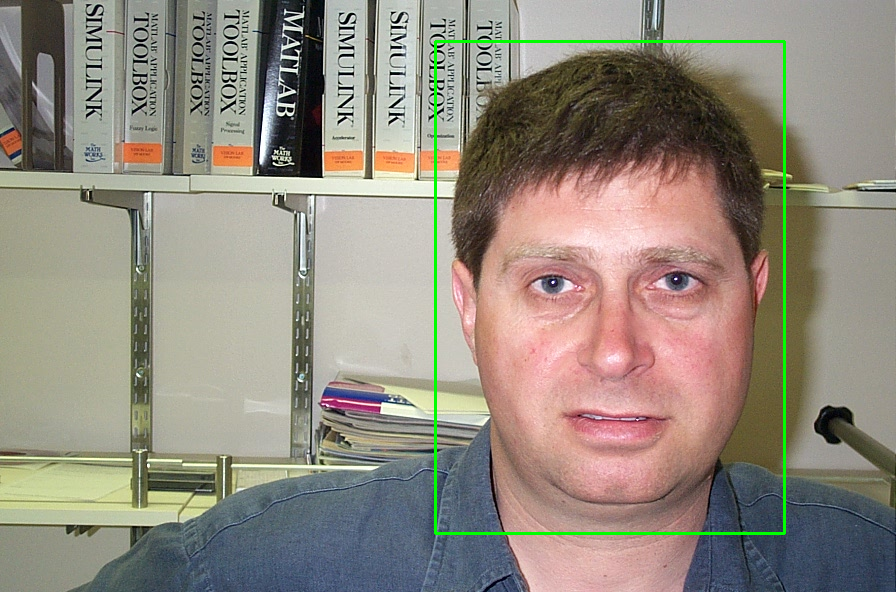

In [6]:
image = cv2.imread('/content/data/caltech_faces/person_001/image_0001.jpg')
(xBL, yBL, xTL, yTL, xTR, yTR, xBR, yBR) = bb_data[0].astype("int")
cv2.rectangle(image,(xTL,yTL),(xBR,yBR),(0, 255, 0),thickness=2)
cv2_imshow(image)

Vamos então, passar por cada diretório da base de dados carregando as imagens e recortando as faces de acordo com os BBs. Esse passo é importante porque queremos extrair a informação somente da parte relevante da imagem (a face).

In [7]:
# lista para armazenas as faces que vão ser extraídas das imagens
data = []
# lista para armazenar os rótulos das faces
labels = []
# define o diretório principal do conjunto de dados
main_dir = os.listdir(path)

# para cada diretorio correspondente a uma pessoa
for person in sorted(main_dir):
  # define o caminho atual de trabalho
  current_path = path + person + '/'
  # verifica se estamos, de fato, listando um diretório
  if os.path.isdir(current_path):
    # carrega todas as imagens da pessoa do diretorio
    image_paths = sorted(glob(current_path+'*.jpg'))
    # para cada imagem da pessoa
    for image_path in image_paths:
      # carrega a imagem
      image = cv2.imread(image_path)
      # converte para a escala de cinza
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # extrai o índice da pessoa para buscar o BB
      k = int(image_path[image_path.rfind("_") + 1:][:4]) - 1
      # extrai as informações de BB para aquela imagem
      (xBL, yBL, xTL, yTL, xTR, yTR, xBR, yBR) = bb_data[k].astype("int")
      # recorta somente a face da pessoa para compor o conjunto de dados
      face = gray[yTL:yBR, xTL:xBR]
      # redimensionando a imagem para um tamanho padrão
      face = cv2.resize(face,(47, 62))
      # converte o formato para vetor flat
      #face = face.flatten()
      # anexa a face ao conjunto de dados
      data.append(face)
      # anexa a informação de rótulo da imagem
      labels.append(image_path.split("/")[-2])

# converte a matriz de dados e rótulos para um NumPy array  
data = np.array(data)
labels = np.array(labels)

In [8]:
# imprime formato dos dados para conferência
print(data.shape)
print(labels.shape)

(445, 62, 47)
(445,)


Após esse processo, cada imagem da base de dados ficará semelhante a essa:

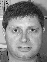

In [9]:
cv2_imshow(data[0])

Como estamos utilizando o OpenCV, é comum codificar os rótulos como números e não como strings. Dessa forma, foi utilizado o módulo `LabelEnconder` para fazer a conversão.

In [10]:
le = LabelEncoder()
le.fit_transform(labels)

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,  3,  3,
        3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,  3,
        4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  4,  4,  4,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,
        7,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9, 10, 10, 10, 10, 10,
       11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
       12, 12, 12, 12, 12, 12, 12, 12, 13, 13, 13, 13, 13, 13, 13, 13, 13,
       13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14,
       14, 14, 14, 14, 14

A base de dados tem algumas características importantes a serem destacadas. Vamos ver, por exemplo, como está a distribuição dos dados entre as classes.

In [11]:
# lista que vai armazenar a quantidade de faces para cada pessoa
labels_count = []
for l in np.unique(le.fit_transform(labels)):
  # verifica quantos dos exemplos do conjunto de dados são do rótulo l
  locations = np.where(le.fit_transform(labels) == l)
  # anexa a lista que guarda a quantidade 
  labels_count.append(len(locations[0]))

print(f'Número de pessoas diferentes na base: {len(np.unique(le.fit_transform(labels)))}')
print(f'Pessoa com mais faces na base: {np.max(labels_count)}')
print(f'Pessoa com menos faces na base: {np.min(labels_count)}')
print(f'Média de faces por pessoa: {np.mean(labels_count)}')
print(f'Desvio padrão de faces por pessoa: {np.std(labels_count)}')

Número de pessoas diferentes na base: 26
Pessoa com mais faces na base: 29
Pessoa com menos faces na base: 5
Média de faces por pessoa: 17.115384615384617
Desvio padrão de faces por pessoa: 7.433432394241795


Podemos ver que existe um desbalanceamento grande entre as classes. Para que consigamos construir um bom classificador, devemos: 
1. obter mais imagens das pessoas que estão com poucas imagens; ou
2. retirar as pessoas que possuem uma quantidade de imagens menor que um determinado limiar.

Vamos optar por essa segunda opção para fins de simplificação e o limiar utilizado vai ser um valor maior que a média considerando que temos um desvio padrão relativamente alto. Nesse caso, 21 imagens.

In [12]:
min_faces = 21
valid_idxs = []

# loop nos rótulos únicos
for label in np.unique(le.fit_transform(labels)):
  # pega os índices no array de rótulos que coincidem com o rótulo atual.      
  label_idxs = np.where(le.fit_transform(labels) == label)[0]

  # só processa se o número necessário de faces ainda não foi atingido.      
  if len(label_idxs) >= min_faces:				
    # adiciona os índices do rótulo atual na lista de índices válidos
    valid_idxs.extend(label_idxs)

# atualiza o conjunto de dados
data = data[valid_idxs]
labels = labels[valid_idxs]

Após essa filtragem, a base de dados ficou com a seguinte configuração:

In [13]:
# verificando o número de pessoas após a filtragem
print(f'Número de pessoas diferentes na base: {len(np.unique(le.fit_transform(labels)))}')
# verificando tamanho do conjunto de dados após a validação
print(f'Formato dos dados: {data.shape}')

Número de pessoas diferentes na base: 12
Formato dos dados: (269, 62, 47)


Com os dados e rótulos em suas próprias estruturas de armazenamento, vamos iniciar o processo de construção de modelo. Para isso, vamos dividir o conjunto de dados em treino e teste.

In [14]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [15]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(215, 62, 47)
(215,)
(54, 62, 47)
(54,)


## Construindo o Classificador

Com os dados devidamente separados, vamos construir um reconhecedor de faces utilizando o método do OpenCV `createLBPHFaceRecognizer` .

Esse método aceita alguns parâmetros:
- `radius`: tamanho do raio que deve ser considerado para definir os vizinhos que vão entrar no cálculo do histograma;
- `neighbors`: número de pixels incluídos na construção do histograma.
- `grid_x` e `grid_y`: número de células da matriz M x N utilizada no algoritmo de reconhecimento.

Os valores definidos a seguir são arbitrários e foram definidos por meio de experimentação.

In [16]:
# inicializa o método de LBP face recognition 
recognizer = cv2.face.LBPHFaceRecognizer_create(radius=2, neighbors=16, grid_x=8, grid_y=8)

# treina o reconhecedor baseado em Local Binary Pattern
# o OpenCV possui uma função para isso...
print("[INFO] treinando o modelo...")
recognizer.train(X_train, le.fit_transform(y_train))

[INFO] treinando o modelo...


Depois de treinar o modelo, vamos agora testar.

In [17]:
from tqdm.notebook import tqdm_notebook as tqdm

# inicializa a lista de predições e valores de confiança
print("[INFO] obtendo predições...")
predictions = []
confidence = []

# loop no conjunto de testes
for i in tqdm(range(0, len(X_test))):	
  # classifica a face a atualiza as listas de predições e valores de confiança  
	(prediction, conf) = recognizer.predict(X_test[i])
	predictions.append(prediction)
	confidence.append(conf)

[INFO] obtendo predições...


  0%|          | 0/54 [00:00<?, ?it/s]

In [18]:
# mostra o relatório com dados de classificação
print(classification_report(le.fit_transform(y_test), predictions,target_names=np.unique(y_test)))

              precision    recall  f1-score   support

  person_001       0.80      1.00      0.89         4
  person_004       1.00      1.00      1.00         5
  person_005       1.00      1.00      1.00         3
  person_006       1.00      1.00      1.00         5
  person_009       1.00      1.00      1.00         3
  person_014       1.00      1.00      1.00         8
  person_015       1.00      1.00      1.00         3
  person_016       1.00      1.00      1.00         3
  person_020       1.00      0.89      0.94         9
  person_023       1.00      1.00      1.00         4
  person_025       0.75      1.00      0.86         3
  person_026       1.00      0.75      0.86         4

    accuracy                           0.96        54
   macro avg       0.96      0.97      0.96        54
weighted avg       0.97      0.96      0.96        54



## Resultados

Vejam que com um simples método de decodificação e com um algoritmo de classificação simples ($1$-NN) foi possível obter 100% de acurácia. É óbvio que em situações mais complexas, o método tende a se degenerar, mas para boa parte dos casos de verificação de faces em cenários pouco complexos, esse tipo de abordagem é mais que suficiente para realizar a tarefa de reconhecimento facial.

Vamos veriricar o resultado mostrando algumas faces aleatórias sendo classificadas e mostrando o valor de confiança do método.

[INFO] Predição: person_006, Real: person_006, Confiança: 192.97183418437467


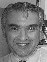

[INFO] Predição: person_014, Real: person_014, Confiança: 174.63202670025942


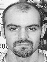

[INFO] Predição: person_023, Real: person_023, Confiança: 185.7326561442025


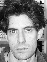

[INFO] Predição: person_020, Real: person_020, Confiança: 198.30240516584368


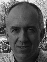

[INFO] Predição: person_025, Real: person_025, Confiança: 167.7590334412104


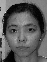

In [20]:
for i in np.random.randint(0, high=X_test.shape[0], size=5):
	# redimensiona a face para ficar mais visível na exibição  
	print(f'[INFO] Predição: {le.inverse_transform([predictions[i]])[0]}, Real: {y_test[i]}, Confiança: {confidence[i]}')
	face = X_test[i]
	cv2_imshow(face)

# Eigenfaces

Apesar de efieciente o algoritmo LBP necessitar de um certo "gabarito" ponderado para entender uma face. O ideal é que seja possível extrair características de uma face de maneira mais automática. O método *Eigenfaces* já é considerado antigo, mas continua sendo um trabalho seminal na área de Visão Computacional. 

Esse método se baseia na ideia de extrair componentes principais da imagem (baseado no algoritmo de PCA - *Principal Componente Analysis*) para caracterizar as faces. 

## Base de dados

Para demonstrar e explicar o algoritmo, vamos utilizar a mesma base de dados anterior, a CALTECH Faces Dataset. Vamos carregar a base utilizando basicamente o mesmo pipeline de antes, com uma única diferença: os dados devem ser *flatten* ao armazenar na matriz de dados.

In [21]:
#imagePaths = sorted(list(paths.list_images(datasetPath)))
path = '/content/data/caltech_faces/'
# carrega as informações sobre bounding boxes armazenadas no formato Matlab
bb_data = io.loadmat(path + 'ImageData.mat')
# mostrando o formato dos dados de BBs
bb_data = bb_data["SubDir_Data"].T

Ao carregar as imagens e transformá-las para escala de cinza, temos um *bitmap* de pixels de tamanho $k$ por $k$ (para imagens quadradas... para as retangulares, o raciocício é o mesmo).

A primeira coisa a fazer para constuir uma base de dados é vetorizar cada imagem para agrupá-las em uma matriz, de forma que cada linha seja uma imagem e as colunas representem seus pixels. A matriz $M$ contém vai conter $Z$ linhas (imagens) e $k^2$ colunas.

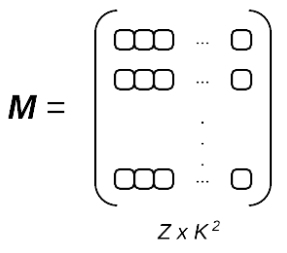

É justamente a partir dessa matriz que o método PCA é aplicado para extrair os elementos básicos do algoritmo *eigenfaces*: os autovalores e autovetores.

In [22]:
# lista para armazenas as faces que vão ser extraídas das imagens
data = []
# lista para armazenar os rótulos das faces
labels = []
# define o diretório principal do conjunto de dados
main_dir = os.listdir(path)

# para cada diretorio correspondente a uma pessoa
for person in sorted(main_dir):
  # define o caminho atual de trabalho
  current_path = path + person + '/'
  # verifica se estamos, de fato, listando um diretório
  if os.path.isdir(current_path):
    # carrega todas as imagens da pessoa do diretorio
    image_paths = sorted(glob(current_path+'*.jpg'))
    # para cada imagem da pessoa
    for image_path in image_paths:
      # carrega a imagem
      image = cv2.imread(image_path)
      # converte para a escala de cinza
      gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
      # extrai o índice da pessoa para buscar o BB
      k = int(image_path[image_path.rfind("_") + 1:][:4]) - 1
      # extrai as informações de BB para aquela imagem
      (xBL, yBL, xTL, yTL, xTR, yTR, xBR, yBR) = bb_data[k].astype("int")
      # recorta somente a face da pessoa para compor o conjunto de dados
      face = gray[yTL:yBR, xTL:xBR]
      # redimensionando a imagem para um tamanho padrão
      face = cv2.resize(face,(47, 62))
      # converte o formato para vetor flat
      face = face.flatten()
      # anexa a face ao conjunto de dados
      data.append(face)
      # anexa a informação de rótulo da imagem
      labels.append(image_path.split("/")[-2])

# converte a matriz de dados e rótulos para um NumPy array  
data = np.array(data)
labels = np.array(labels)

In [23]:
# imprime formato dos dados para conferência
print(data.shape)
print(labels.shape)

(445, 2914)
(445,)


Após conferido o formato do nosso array de dados, vamos aproveitar para realizar os mesmos procedimentos de remoção das classes com poucos exemplos e de divisão dos dados em conjunto de treinamento e teste.

In [24]:
min_faces = 21
valid_idxs = []

# loop nos rótulos únicos
for label in np.unique(le.fit_transform(labels)):
  # pega os índices no array de rótulos que coincidem com o rótulo atual.      
  label_idxs = np.where(le.fit_transform(labels) == label)[0]

  # só processa se o número necessário de faces ainda não foi atingido.      
  if len(label_idxs) >= min_faces:				
    # adiciona os índices do rótulo atual na lista de índices válidos
    valid_idxs.extend(label_idxs)

# atualiza o conjunto de dados
data = data[valid_idxs]
labels = labels[valid_idxs]

In [25]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [26]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(215, 2914)
(215,)
(54, 2914)
(54,)


## PCA

O próximo passo é aplicar o algoritmo PCA que, basicamente, faz os seguintes passos:

1. calcula a média $\mu_i$ de cada coluna da matriz, fornecendo a intensidade média dos pixels na localização $(x,y)$ do conjunto de imagens.
2. subtrai a média $\mu_i$ de cada coluna $c_i$ com o objeto de entralizar o dados com relação a média.
3. calcula a matriz de covariância dos dados.
4. realiza a decomposição de autovalores da matriz de covariância para obter os autovalores $\lambda_i$ e os autovetores $X_i$.
5. ordena os autovetores com base dos autovalores (do maior para o menor).
6. seleciona os primeiros $N$ autovetores com seus respectivos autovalores.
7. transforma os dados de entrada (produto interno) projetando-os no espaço criado pelos $N$ autovetores - os dados transformados são as chamadas *eigenfaces*.

No contexto da nossa implementação, o modelo PCA é inicializado por meio da função `PCA()`. Após realizado o procedimento, uma nova matriz $V$ com formato $NxK^2$ é criada com a função `pca.fit_transform()`, em que $N$ é igual ao número de componentes (16 no nosso caso) e $K^2$ é o número de dimensões de cada imagem:

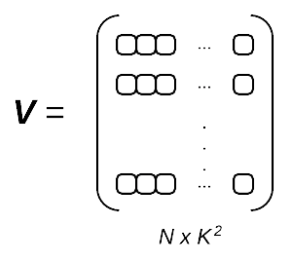

In [27]:
from sklearn.decomposition import PCA

# calcula as eigenfaces (aplicando PCA)
print("[INFO] criando as eigenfaces...")
pca = PCA(svd_solver="randomized", n_components=X_train.shape[0], whiten=True)
#pca = PCA(svd_solver="randomized", n_components=16, whiten=True)
train_data = pca.fit_transform(X_train)

[INFO] criando as eigenfaces...


Executamos o PCA para ter o mesmo número de componentes que o total de imagens, para fins de explicação.

In [28]:
pca.components_.shape

(215, 2914)

A partir disso, pelo fato de cada componente ter as mesmas dimensões que nossas imagens originais, podemos entender que cada linha dessa nova matriz é uma *eigenface*. As *eigenfaces* são as representações das faces originais no novo espaço vetorial criado pelo algoritmo PCA. Para entender melhor, vamos analisar as imagens abaixo, vamos plotar algumas dessas *eigenfaces*, mais precisamente, as 16 primeiras. Além disso, vamos mostrar o valor médio das eigenfaces, o que poderia ser interpretado como uma *face média* dentre todas aquelas do conjunto de dados.

Eigenface médio: 


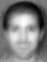

16 componentes com maior variância: 


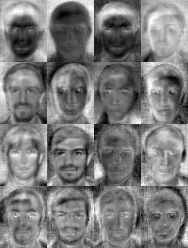

In [29]:
from sklearn.decomposition import PCA
from skimage import exposure

# plotando a eigenface média do conjunto de dados
print('Eigenface médio: ')
mean = pca.mean_.reshape(62,47)
mean = exposure.rescale_intensity(mean, out_range=(0, 255)).astype("uint8")
cv2_imshow(mean)

# tamanho original das faces
(w,h) = (47,62)
# criando canvas para plotar todas as 16 imagens juntas
#combined = np.zeros((h*4,w*4), np.uint8)*255
combined = []

# para cada componente
for (i, component) in enumerate(pca.components_[:16]):
  component = component.reshape((62, 47))
  component = exposure.rescale_intensity(component, out_range=(0, 255)).astype("uint8")
  combined.append(component)

r1 = np.hstack(combined[0:4])
r2 = np.hstack(combined[4:8])
r3 = np.hstack(combined[8:12])
r4 = np.hstack(combined[12:16])
print('16 componentes com maior variância: ')
cv2_imshow(np.vstack((r1,r2,r3,r4)))

O eigenface médio, como próprio nome indica, traz a face média no espaço dos componentes principais (valor médio de cada componente). Os 16 componentes apresentados são aqueles que mais variam com relação a média.

Regiões mais claras correspondem a maior variância, enquanto que regiões mais escuras indicam pouca variância.
A partir disso, podemos ver que as pessoas costumam variar bastante na região do cabelo, dos olhos sobrancelas, nariz.

A partir dos componentes, podemos escolher quantos queremos utilizar com base no montante de variância acumulado por esses componentes. Vamos mostrar o valor acumulado para alguns intervalos de componentes:


In [30]:
# percentual acumulado de variância no 1 primeiro componentes
print(f'Percentual acumulado de variância no primeiro componente: {pca.explained_variance_ratio_[0].sum()}')
# percentual acumulado de variância nos 5 primeiros componentes
print(f'Percentual acumulado de variância nos 5 primeiros componentes: {pca.explained_variance_ratio_[:5].sum()}')
# percentual acumulado de variância nos 10 primeiros componentes
print(f'Percentual acumulado de variância nos 10 primeiros componentes: {pca.explained_variance_ratio_[:10].sum()}')
# percentual acumulado de variância nos 15 primeiros componentes
print(f'Percentual acumulado de variância nos 15 primeiros componentes: {pca.explained_variance_ratio_[:15].sum()}')
# percentual acumulado de variância nos 20 primeiros componentes
print(f'Percentual acumulado de variância nos 20 primeiros componentes: {pca.explained_variance_ratio_[:20].sum()}')
# percentual acumulado de variância nos 25 primeiros componentes
print(f'Percentual acumulado de variância nos 25 primeiros componentes: {pca.explained_variance_ratio_[:25].sum()}')

Percentual acumulado de variância no primeiro componente: 0.19476463402365649
Percentual acumulado de variância nos 5 primeiros componentes: 0.502289225618874
Percentual acumulado de variância nos 10 primeiros componentes: 0.6311605798990796
Percentual acumulado de variância nos 15 primeiros componentes: 0.6918607157732009
Percentual acumulado de variância nos 20 primeiros componentes: 0.729835490744818
Percentual acumulado de variância nos 25 primeiros componentes: 0.7580922996673263


Note que esse valor vai subindo a medida que usamos mais componentes. No entanto, a variância normalmente está presente nos primeiros componentes e os seguintes adicionam pouca variância aos dados.

No exemplo dado, o primeiro componente sozinho carrega quase 20% da variância. Os cinco primeiros componentes contém mais de 50% e os 10 primeiros, mais de 63%. A partir desse ponto, a variância adicionada é pouca. Essa relação pode ser vista no gráfico a seguir, onde plotamos a quantidade de variância acumulada (eixo y) de acordo com o número de componentes (eixo x):

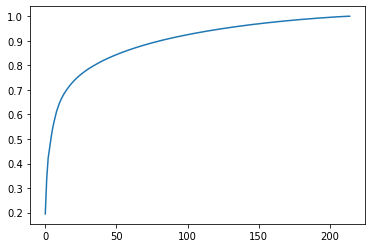

In [31]:
import matplotlib.pyplot as plt

acc_var = []
acc = 0
for i, e_var in enumerate(pca.explained_variance_ratio_):
  acc_var.append(acc+e_var)
  acc += e_var
  
plt.plot(range(pca.n_components_), acc_var)

A partir do gráfico, é possível notar que a quantidade de variância acumulada cresce vertiginosamente no início, mas o ritmo de crescimento cai bem antes de chegar nos 50 componentes.

Para o nosso experimento, podemos utilizar um valor próximo a 20, que deve gerar um resultado satisfatório.

Para demonstrar que o método `pca` pode ser inicializado de uma maneira que já considera esse parâmetro para construir nosso conjunto de dados, vamos executar novamente, mas configurando o parâmetro `n_components` para 20.

In [32]:
# calcula as eigenfaces (aplicando PCA)
print("[INFO] criando as eigenfaces...")
pca = PCA(svd_solver="randomized", n_components=20, whiten=True)
train_data = pca.fit_transform(X_train)

[INFO] criando as eigenfaces...


## Identificação

Dado que temos as *eigenfaces*, podemos representar uma nova face através do produto interno entre a entrada e as $N$ *eigenfaces*. Isso, na verdade, permite que a gente possa representar cada face como uma combinação linear dos componentes principais. Por exemplo:

>Face a ser buscada = 36% da *eigenface* 1 + -8% da *eigenface 2* + ... + 21% da *eigenface N*.

Para detectar quem é uma nova pessoa, basta medir a distância euclidiana (ou outra medida de proximidade) da representação no espaço de *eigenface* de uma nova face todas as faces da base e selecionar aquela com a menor distância.

Podemos também partir para uma abordagem mais precisa com algoritmos de aprendizado de máquina mais robustos, como o SVM, por exemplo.

Vemos isso a seguir com código abaixo.

In [33]:
from sklearn.svm import SVC

# treinar um classificador com as representações eigenface
print("[INFO] treinando classificador...")
model = SVC(kernel="rbf", C=10.0, gamma=0.001, random_state=84)
model.fit(train_data, y_train)

# avaliando classificador
print("[INFO] avaliando modelo...")
predictions = model.predict(pca.transform(X_test))
print(classification_report(y_test, predictions))

[INFO] treinando classificador...
[INFO] avaliando modelo...
              precision    recall  f1-score   support

  person_001       1.00      1.00      1.00         4
  person_004       1.00      1.00      1.00         5
  person_005       1.00      1.00      1.00         3
  person_006       1.00      1.00      1.00         5
  person_009       1.00      1.00      1.00         3
  person_014       1.00      1.00      1.00         8
  person_015       1.00      1.00      1.00         3
  person_016       1.00      1.00      1.00         3
  person_020       1.00      1.00      1.00         9
  person_023       1.00      1.00      1.00         4
  person_025       1.00      1.00      1.00         3
  person_026       1.00      1.00      1.00         4

    accuracy                           1.00        54
   macro avg       1.00      1.00      1.00        54
weighted avg       1.00      1.00      1.00        54



Notamos que o classificador teve um resultado também muito bom. Existiu uma confusão com algumas imagens.

Vamos ver algumas amostras de classificação.

[INFO] Predição: person_006, Real: person_006


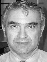

[INFO] Predição: person_001, Real: person_001


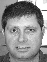

[INFO] Predição: person_025, Real: person_025


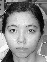

[INFO] Predição: person_001, Real: person_001


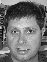

[INFO] Predição: person_025, Real: person_025


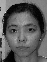

In [34]:
for i in np.random.randint(0, high=X_test.shape[0], size=5):
	# pega a imagem e classifica
	face = X_test[i].reshape((62, 47)).astype("uint8")
	prediction = model.predict(pca.transform(X_test[i].reshape(1, -1)))
	# redimensiona para ficar mais fácil a visualização
	print(f'[INFO] Predição: {prediction[0]}, Real: {y_test[i]}')
	cv2_imshow(face)

O resultado não implica que o método de *eigenfaces* é melhor que o LBP. Os dois métodos são robustos para algumas situações, mas frágeis para outras. Os métodos são criticados, por exemplo, porque apresentam restrições quanto ao alinhamento facial, que devem ser semelhantes para todas as imagens, o que é muito difícil de se fazer no mundo real. Mas, em situações controladas (como um controle de acesso) os algoritmos podem ser bastante úteis.

In [ ]:
# Caso queira executar o notebook novamente, limpe os dados
!rm -rf '/content/data/'